# Case study: Farrell zebrafish embryo data

This notebook generates results for a case study that uses a [zebrafish embryo Drop-Seq dataset](https://singlecell.broadinstitute.org/single_cell/study/SCP162/single-cell-reconstruction-of-developmental-trajectories-during-zebrafish-embryogenesis).

We compare the embedding using a standard variational autoencoder (VAE), default ViVAE and a ViVAE encoder-only (parametric MDS-like) model.
To this end, we will plot encoder indicatrices for each model.

<hr>

## **0.** Load required modules

In addition to `ViVAE`, `ViScore` and their dependenceis, you will need to have `umap` and `SQuadMDS` installed in your conda environment.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import copy
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors
import ViVAE
import ViScore
from sklearn.manifold import TSNE
import torch
from umap import UMAP
from SQuadMDS import SQuadMDS
from sklearn.manifold import TSNE
from matplotlib.patches import Rectangle

## **1.** Load input data

See the ViScore [benchmarking](https://github.com/saeyslab/ViScore/tree/main/benchmarking) page for instructions on how to obtain and pre-process the Farrell data.

In [2]:
## Load input data

dataset = 'Farrell'

pc   = np.load(os.path.join('..', 'data', f'{dataset}_input.npy'),          allow_pickle=True)
pc_d = np.load(os.path.join('..', 'data', f'{dataset}_input_denoised.npy'), allow_pickle=True)
labs = np.load(os.path.join('..', 'data', f'{dataset}_labels.npy'),         allow_pickle=True)

meta = pd.read_csv('../data/Farrell_meta.txt', sep='\t')       # this is the `URD_Dropseq_Meta.txt` file from Single Cell Portal

## **2.** Generate embeddings

In [14]:
emb_tsne     = TSNE(n_components=2, random_state=42).fit_transform(pc)
emb_umap     = UMAP(n_components=2, random_state=42).fit_transform(pc)
emb_squadmds = SQuadMDS(n_components=2, random_state=42).fit_transform(pc)

torch.manual_seed(42)
np.random.seed(42)
model_vae = ViVAE.ViVAE(input_dim=pc.shape[1], latent_dim=2, random_state=42)
model_vae.fit(pc, lam_recon=1., lam_kldiv=1., lam_mds=0.)

torch.manual_seed(42)
np.random.seed(42)
model_vivae_enconly = ViVAE.ViVAE(input_dim=pc.shape[1], latent_dim=2, random_state=42)
model_vivae_enconly.fit(pc_d, lam_recon=0., lam_kldiv=1., lam_mds=10.)

torch.manual_seed(42)
np.random.seed(42)
model_vivae = ViVAE.ViVAE(input_dim=pc.shape[1], latent_dim=2, random_state=42)
model_vivae.fit(pc_d, lam_recon=1., lam_kldiv=1., lam_mds=100.)

emb_vae = model_vae.transform(pc)
emb_vivae_enconly = model_vivae_enconly.transform(pc_d)
emb_vivae = model_vivae.transform(pc_d)

Epoch 1/50	recon: 1372.1326	kldiv: 4.1819	geom: 0.0000	egeom: 0.0000	mds: 0.0000
Epoch 2/50	recon: 514.8182	kldiv: 3.8519	geom: 0.0000	egeom: 0.0000	mds: 0.0000
Epoch 3/50	recon: 291.1538	kldiv: 2.6838	geom: 0.0000	egeom: 0.0000	mds: 0.0000
Epoch 4/50	recon: 192.0464	kldiv: 1.9393	geom: 0.0000	egeom: 0.0000	mds: 0.0000
Epoch 5/50	recon: 144.8224	kldiv: 1.5115	geom: 0.0000	egeom: 0.0000	mds: 0.0000
Epoch 6/50	recon: 117.8662	kldiv: 1.2234	geom: 0.0000	egeom: 0.0000	mds: 0.0000
Epoch 7/50	recon: 98.1659	kldiv: 1.0430	geom: 0.0000	egeom: 0.0000	mds: 0.0000
Epoch 8/50	recon: 83.7017	kldiv: 0.9181	geom: 0.0000	egeom: 0.0000	mds: 0.0000
Epoch 9/50	recon: 73.1641	kldiv: 0.8143	geom: 0.0000	egeom: 0.0000	mds: 0.0000
Epoch 10/50	recon: 64.6982	kldiv: 0.7343	geom: 0.0000	egeom: 0.0000	mds: 0.0000
Epoch 11/50	recon: 57.8691	kldiv: 0.6707	geom: 0.0000	egeom: 0.0000	mds: 0.0000
Epoch 12/50	recon: 52.2895	kldiv: 0.6260	geom: 0.0000	egeom: 0.0000	mds: 0.0000
Epoch 13/50	recon: 47.7346	kldiv: 0.5743	g

## **3.** Plot embeddings with cells labelled by developmental stages

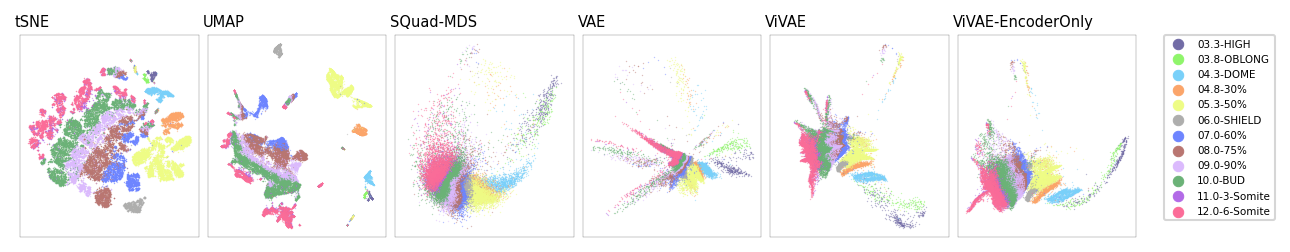

In [139]:
palette = ['#726ca6','#8ff56b','#79d0f9','#fba56a','#eefc85','#aeaead','#6e85ff','#b97671','#dbbafd','#6bb277',
           #'#b7fbce','#6af1b0',
           '#b26ae7','#fb6c98','#fdc4b8','#c1c86c','#699dc0','#d889c1','#a89ef4','#95d598',
           '#757469','#78fefe','#f1f7c3','#b2ddfb','#cad9a3','#9b9f69','#aa7caa','#74c7c0','#face7e','#fe9cdb',
           '#ce9f81','#bafc85','#fdd5f1','#e97f6c','#8d89d7','#839095','#d68ef9','#a5d1ca','#d1fcfe','#6eaaee',
           '#f799a1','#d7b2c8','#70d87a','#99faa9','#6b70d4','#dbd8d2','#fb77c9','#88f4d2','#d17a98','#90b2d3',
           '#aafef7','#debc9d','#d2e96a','#96c96a','#8c6ff5','#927286','#7cff8e','#80b19e','#adbcfa','#d86fdd',
           '#aee276','#eee1a5','#feb6fe','#996dc9','#b699cc','#ad908d','#76946b','#d2fea8','#a7b883','#b881fe',
           '#69e7da','#92e8f5','#b5b6d4','#dadcfa','#bf6cbe','#9199b6','#70d79f','#6afd6e','#dcb26c','#d69fae',
           '#b5eab1','#fce96a','#6987aa','#8dadfc','#938afd','#c7ebe4','#de6a7f','#938669','#c4cce8','#e36daf',
           '#e8f1e8','#86e1b6','#ff6b69','#ed9ffc','#87d7d6','#feb58d','#b96a93','#dcd189','#adc9a7']
mpl.rcParams['axes.linewidth'] = 0.1
pops = np.unique(labs)
methods = ['tSNE', 'UMAP', 'SQuad-MDS', 'VAE', 'ViVAE', 'ViVAE-EncoderOnly']
nmet = len(methods)
fig, ax = plt.subplots(nrows=1, ncols=nmet, figsize=(1.6*nmet, 1.75), dpi=150)
fig.subplots_adjust(wspace=.05)
handles = []
labels = []
embs = [emb_tsne, emb_umap, emb_squadmds, emb_vae, emb_vivae, emb_vivae_enconly]
s = .01
for i, method in enumerate(methods):
    emb = embs[i]
    for j, pop in enumerate(pops):
        idcs = np.where(labs==pop)[0]
        if i==0:
            ax[i].scatter(emb[idcs,0], emb[idcs,1], s=s, label=pop, c=palette[j], alpha=1., linewidth=.5)
        else:
            ax[i].scatter(emb[idcs,0], emb[idcs,1], s=s, c=palette[j], alpha=1., linewidth=.5)
    #ax[i].tick_params(axis='both', labelsize=5)
    ax[i].tick_params(axis='both', labelbottom=False, labelleft=False, bottom=False, left=False)
    ax[i].axis('equal')
    ax[i].set_title(methods[i], size=7, ha='left', x=-.03, y=.98)
    if i==(len(methods)-1):
        l = fig.legend(bbox_to_anchor=(1., .9), fontsize=5, markerscale=50.)
fig.savefig('Farrell_A_stages.png', bbox_inches='tight', dpi=600, transparent=True)
fig.savefig('Farrell_A_stages.svg', bbox_inches='tight', transparent=True)

## **4.** Plot embeddings with highlighted cells in selected lineages

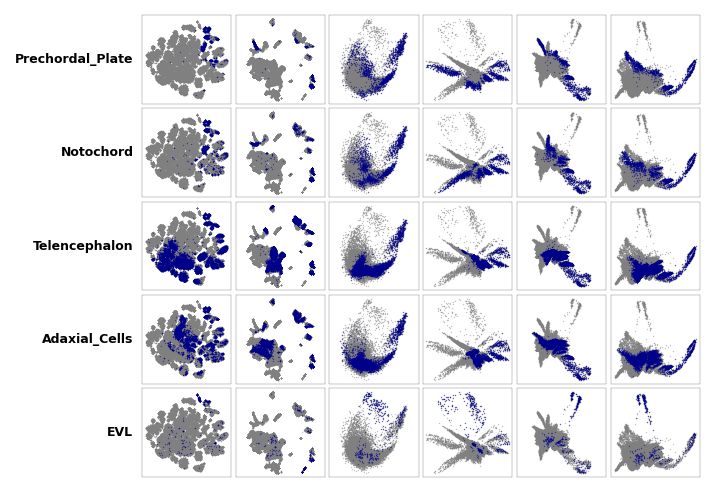

In [140]:
cols = ['Prechordal_Plate', 'Notochord', 'Telencephalon', 'Adaxial_Cells', 'EVL']

methods = ['tSNE', 'UMAP', 'SQuad-MDS', 'VAE', 'ViVAE', 'ViVAE-EncoderOnly']
nmet = len(methods)
ncol = len(cols)
fig, ax = plt.subplots(nrows=ncol, ncols=nmet, figsize=(.8*nmet, .8*ncol), dpi=150)
fig.subplots_adjust(wspace=.05, hspace=.05)
embs = [emb_tsne, emb_umap, emb_squadmds, emb_vae, emb_vivae, emb_vivae_enconly]
mpl.rcParams['axes.linewidth'] = 0.1
for i, col in enumerate(cols):
    idcs = np.where([x in ['True', 'TRUE'] for x in meta[f'Lineage_{col}'][1:]])[0]
    nmet = len(methods)
    handles = []
    labels = []
    s = .01
    for j, method in enumerate(methods):
        emb = embs[j]
        ax[i][j].scatter(emb[:,0], emb[:,1], s=s, c='grey', linewidth=.5)
        ax[i][j].scatter(emb[idcs,0], emb[idcs,1], s=s, c='darkblue', linewidth=.5)
        ax[i][j].tick_params(axis='both', bottom=False, left=False, labelbottom=False, labelleft=False)
        ax[i][j].axis('equal')

for a, row in zip(ax[:,0], cols):
    a.annotate(row, xy=(0, .5), xytext=(0, 0), xycoords=a.yaxis.label, textcoords='offset points', size=6, weight='bold', ha='right', va='center')

#fig.suptitle('B', x=0.03, y=.91, size=12, weight='bold')
fig.savefig('Farrell_B_stages.png', bbox_inches='tight', dpi=600, transparent=True)
fig.savefig('Farrell_B_stages.svg', bbox_inches='tight', transparent=True)

## **5.** Compute and plot encoder indicatrices for VAE-based models

In [141]:
ei_vae           = model_vae.encoder_indicatrices(X=pc, radius=1e-1, n_steps=21, n_polygon=10000)
ei_vivae         = model_vivae.encoder_indicatrices(X=pc_d, radius=5e-1, n_steps=14, n_polygon=10000)
ei_vivae_enconly = model_vivae_enconly.encoder_indicatrices(X=pc_d, radius=1e-1, n_steps=22, n_polygon=10000)
# try and reflect difference in scales across embeddings in the `n_steps`
# !!! what matters is the shape distortion (ellipses) and the inconsistence in size of indicatrices--not the absolute sizes

The following cell generates a zoomed-in part of the ViVAE embedding and computed indicatrices for it.
This assumes that PyTorch actually manages to keep things reproducible.
If not, you may want to adjust the coordinates.

In [142]:
zoom_idcs = np.logical_and.reduce([
    emb_vivae[:,0]>(3),
    emb_vivae[:,0]<(7),
    emb_vivae[:,1]>(-3),
    emb_vivae[:,1]<(1)
])
emb_vivae_zoom = emb_vivae[zoom_idcs]
pc_d_zoom = pc_d[zoom_idcs]
ei_vivae_zoom = model_vivae.encoder_indicatrices(X=pc_d_zoom, radius=1e-3, n_steps=25, n_polygon=1000)

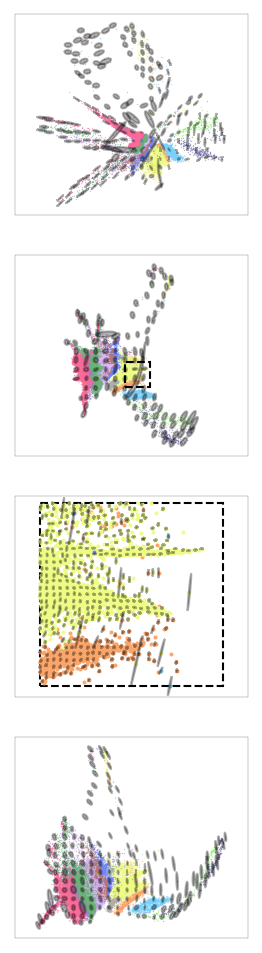

In [143]:
mpl.rcParams['axes.linewidth'] = 0.1
pops = np.unique(labs)
methods = ['VAE', 'ViVAE', 'ViVAE-EncoderOnly']
nmet = len(methods)
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(2, 8), dpi=150)
fig.subplots_adjust(hspace=.2)
handles = []
labels = []
methods = ['VAE', 'ViVAE', 'ViVAE (zoomed-in)','ViVAE-EncoderOnly']
embs = [emb_vae, emb_vivae, emb_vivae_zoom, emb_vivae_enconly]
eis = [ei_vae, ei_vivae, ei_vivae_zoom, ei_vivae_enconly]
subset_idcs = [None, None, zoom_idcs, None]

## Scale factors

sfs = [2e1, 3e0, 8e1, 1e1]
for i, method in enumerate(methods):
    si = subset_idcs[i]
    s = 2.
    if si is None:
        s = .01
        si = np.arange(len(labs))
    emb = embs[i]
    ei = eis[i]
    sf = sfs[i]
    for j, pop in enumerate(pops):
        idcs = np.where(labs[si]==pop)[0]
        if i==0:
            ax[i].scatter(emb[idcs,0], emb[idcs,1], s=s, label=pop, c=palette[j], alpha=1., linewidth=.5)
        else:
            ax[i].scatter(emb[idcs,0], emb[idcs,1], s=s, c=palette[j], alpha=1., linewidth=.5)

    if method=='ViVAE':
        rect = Rectangle(xy=(3,-3), width=4, height=4, ls='dashed', lw=1, edgecolor='black', facecolor='none', zorder=1)
        ax[i].add_patch(rect)
    if method=='ViVAE (zoomed-in)':
        ax[i].margins(0.01)
        rect = Rectangle(xy=(3,-3), width=4, height=4, ls='dashed', lw=1, edgecolor='black', facecolor='none', zorder=0)
        ax[i].add_patch(rect)

    pol = ei.get_polygons(scale_factor=sf)
    pol.set_color([0 / 255, 0 / 255, 0 / 255, 0.3])
    ax[i].add_collection(pol)

    #ax[i].tick_params(axis='both', labelsize=5)
    ax[i].tick_params(axis='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    ax[i].axis('equal')
    
#fig.suptitle('C', x=0.03, y=.91, size=12, weight='bold')
fig.savefig('Farrell_C_indicatrices_D_zoom.png', bbox_inches='tight', dpi=600, transparent=True)
fig.savefig('Farrell_C_indicatrices_D_zoom.svg', bbox_inches='tight', transparent=True)